In [1]:
import seaborn as sn
import quandl
API_KEY = "yCev-u-joPYss-FULGkt"
quandl.ApiConfig.api_key = (API_KEY)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [3]:
from sklearn.metrics import  mean_squared_error
import math
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [20]:
def forecast_accuracy(forecast, actual):
    mse = mean_squared_error(actual, forecast)
    return math.sqrt(mse)

Let's retrieve the data

In [6]:
liAuto_df = quandl.get('HKEX/02015')
print(liAuto_df.shape)
liAuto_df.head()

(413, 12)


,Nominal Price,Net Change,Change (%),Bid,Ask,P/E(x),High,Low,Previous Close,Share Volume (000),Turnover (000),Lot Size
Date,,,,,,,,,,,,
2021-08-12,117.0,None,None,117.0,117.1,None,118.5,115.5,NaN,5750.0,673280.0,None
2021-08-13,114.6,None,None,114.6,114.7,None,116.6,113.1,117.0,2584.0,295570.0,None
2021-08-16,106.4,None,None,106.4,106.6,None,112.3,105.3,114.6,4011.0,433676.0,None
2021-08-17,106.3,None,None,106.3,106.6,None,108.9,105.1,106.4,754.0,80487.0,None
2021-08-18,111.4,None,None,111.4,111.7,None,114.0,108.0,106.3,1365.0,151530.0,None


In [8]:
df = pd.DataFrame({'Date': liAuto_df.index.values,
                          'value': liAuto_df['Nominal Price']
                          })
df = df.reset_index(drop=True)
print(df.info())
# df.plot()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413 entries, 0 to 412
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    413 non-null    datetime64[ns]
 1   value   413 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 6.6 KB
None


Let's try to predict the Nominal Price with time series

# ARIMA

ADF Test for Null Hypothesis

In [9]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df.value.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -1.873618
p-value: 0.344572


p-value > 0.05 => Null hypothesis is not true.
Now, to find 'd'

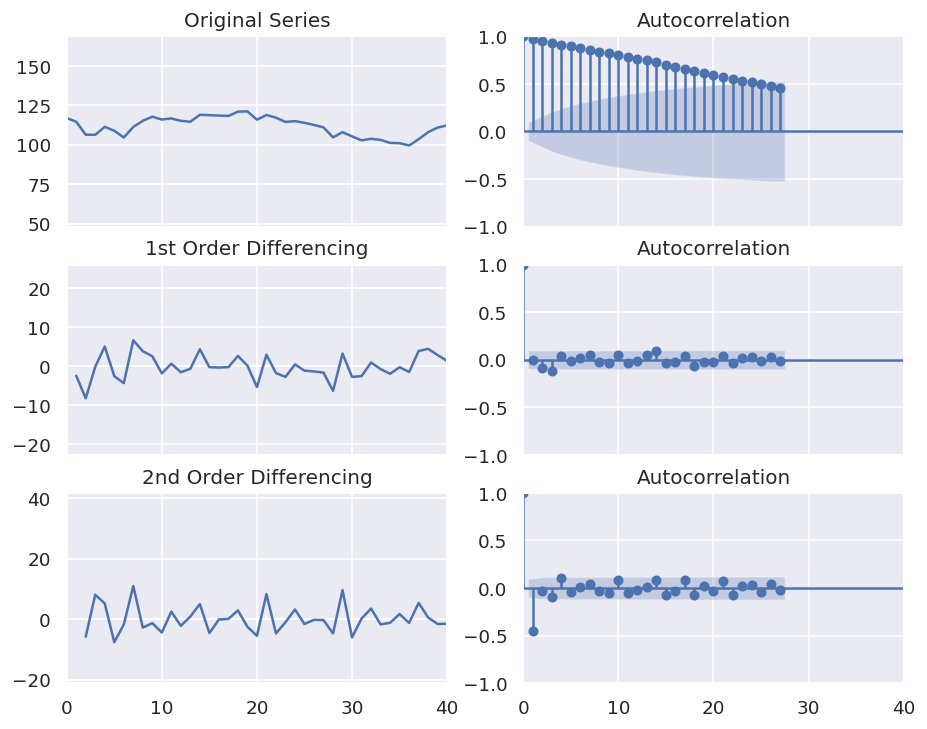

In [10]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})


# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df.value); axes[0, 0].set_title('Original Series')
axes[0, 1].set_xlim([0, 40])
plot_acf(df.value, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.value.diff()); axes[1, 0].set_title('1st Order Differencing')
axes[1, 1].set_xlim([0, 40])
plot_acf(df.value.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.value.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
axes[2, 1].set_xlim([0, 40])
plot_acf(df.value.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

d=1, as the dataset becomes stationary at 1st order differencing

Now, to find AR(p)

/home/ananthNB/.local/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


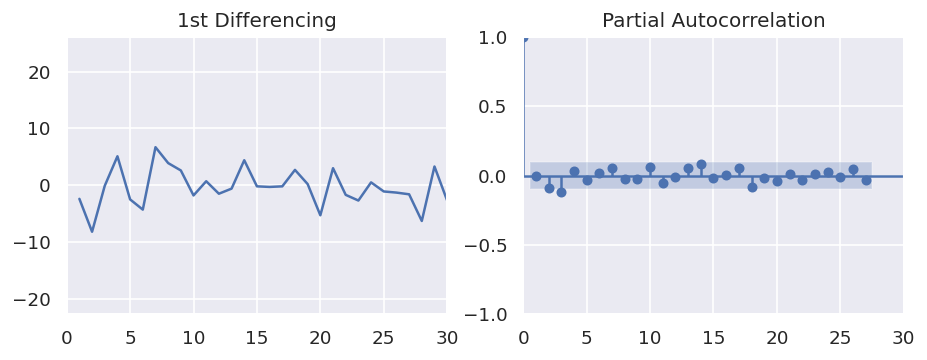

In [11]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.value.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,4))
axes[1].set_xlim([0, 30])
plot_pacf(df.value.diff().dropna(), ax=axes[1])

plt.show()

Since the 3rd lag is significant, p = 3

Now, to find MA(q)

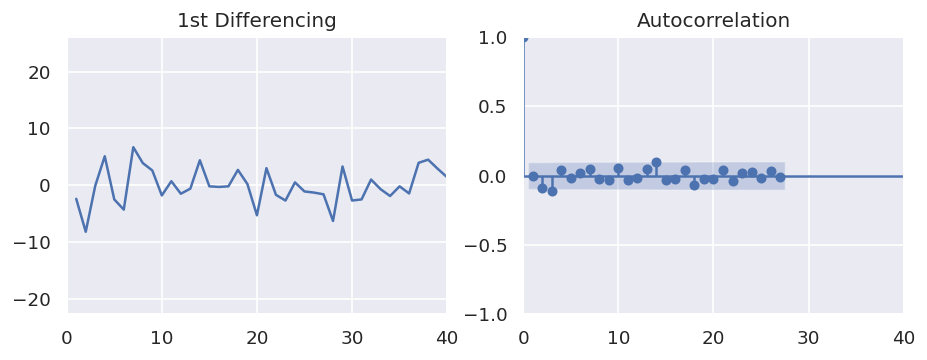

In [12]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.value.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
axes[1].set_xlim([0, 40])
plot_acf(df.value.diff().dropna(), ax=axes[1])

plt.show()

q = 3

Now, to create the model

In [16]:
from statsmodels.tsa.arima.model import ARIMA
train = df[:350]
test = df[350:]
# 1,3,3 ARIMA Model
model = ARIMA(train.value, order=(1,3,3))
fitted = model.fit()
print(fitted.summary())

/home/ananthNB/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  350
Model:                 ARIMA(1, 3, 3)   Log Likelihood               -1052.597
Date:                Wed, 19 Apr 2023   AIC                           2115.193
Time:                        00:57:03   BIC                           2134.440
Sample:                             0   HQIC                          2122.857
                                - 350                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9999      2.031     -0.492      0.623      -4.981       2.981
ma.L1         -0.9997     54.387     -0.018      0.985    -107.597     105.597
ma.L2         -0.9999    108.529     -0.009      0.9

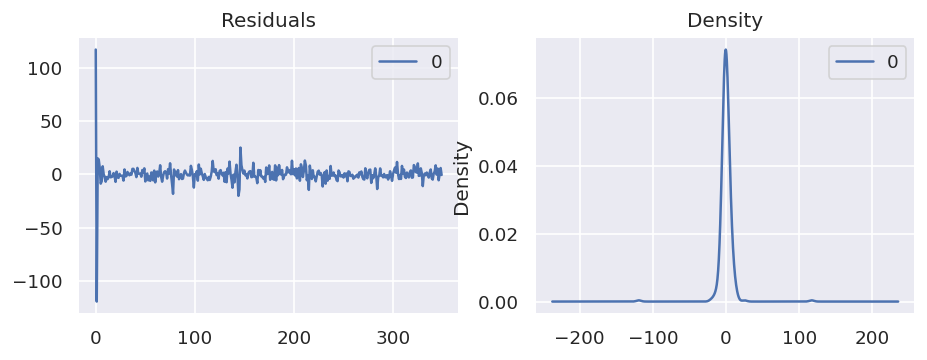

In [17]:
# Plot residual errors
residuals = pd.DataFrame(fitted.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

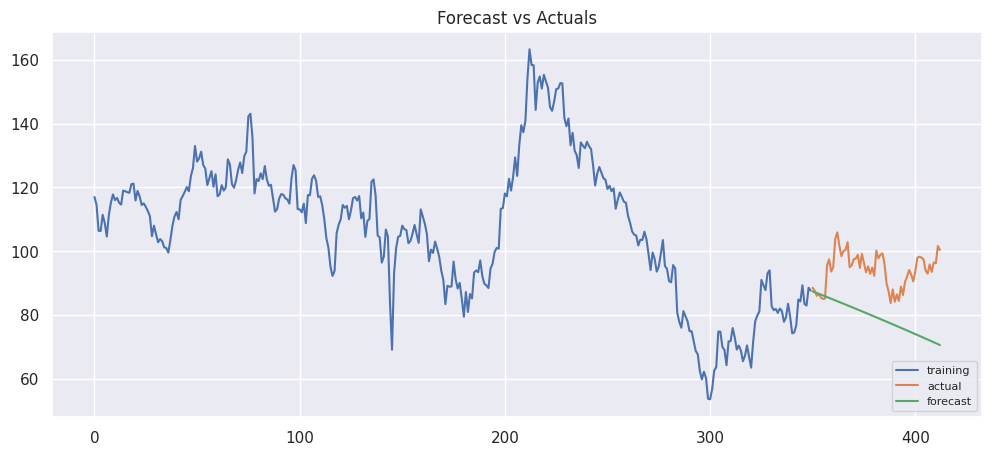

In [25]:
#Forecast
forecast = fitted.predict(start=350, end=412)
# print(forecast)

plt.figure(figsize=(12,5), dpi=100)
plt.plot(train.value, label='training')
plt.plot(test.value, label='actual')
plt.plot(forecast, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='lower right', fontsize=8)
plt.show()

Root Mean Squared Error (MSE)

In [27]:
print(forecast_accuracy(forecast,test.value))
# test.value

16.744146418435246
